# **Tensor Network: Quantum-Motivated Classical Machine Learning**

In this project, we utilized tensor networks to enhance the performance of quantum computers. A tensor network is a technique used to handle complex computations by decomposing high-dimensional tensors into lower-dimensional ones.

Originally, tensor networks were introduced as a classical limitation that quantum computers must overcome. However, in this project, we leveraged these characteristics to train initial parameters for QAOA (Quantum Approximate Optimization Algorithm) with minimal resources. Subsequently, the learned parameters were used to improve the performance of quantum QAOA and further enhance the methods discussed in the RL QAOA phase.






## **Quantum Layer Training Using Tensor Networks**


### **1. Example graph**

In this step, each edge and weight are randomly generated within a range similar to the problem domain.

A QAOA layer that is easy to train with tensor networks follows a **tree structure**. According to [this reference](https://arxiv.org/pdf/1908.08862), tree structures allow for stable contraction of tensors without the risk of exponential growth, enabling efficient QAOA training.

This advantage not only allows tensor networks to accurately approximate quantum circuits but also provides a unique strength: unlike quantum circuits, tensor networks do not require sampling. 

Therefore, even if high-performance QPUs (Quantum Processing Units) become available in the future, tensor networks will continue to provide polynomial benefits by enabling computation without the need for sampling.

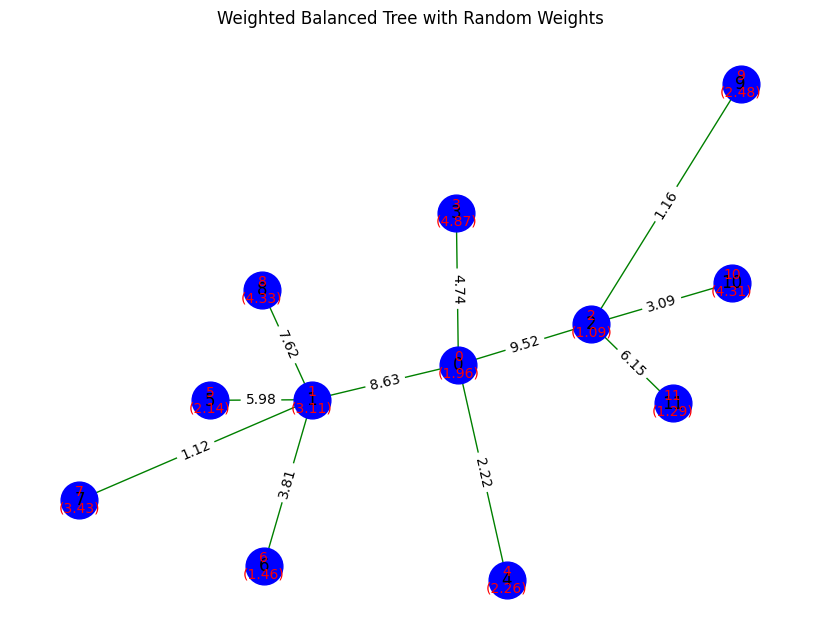

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

def generate_weighted_balanced_tree(n, min_degree=3, node_weight_range=(0, 1), edge_weight_range=(0, 1)):
    """
    Generates a balanced tree graph with n nodes, where each node has at least min_degree connections.
    Assigns random weights to nodes and edges.

    Parameters
    ----------
    n : int
        Number of nodes in the tree.
    min_degree : int, optional (default=3)
        Minimum number of connections each node should have.
    node_weight_range : tuple, optional
        Range of weights to assign to nodes (default=(1, 10)).
    edge_weight_range : tuple, optional
        Range of weights to assign to edges (default=(1, 10)).

    Returns
    -------
    tree : networkx.Graph
        A randomly generated balanced tree with n nodes and assigned weights.
    adjacency_matrix : np.ndarray
        The adjacency matrix representing the tree with node and edge weights.
    node_weights : dict
        Dictionary of nodes with assigned weights.
    """

    # Create an empty graph
    tree = nx.Graph()
    tree.add_node(0)
    node_count = 1
    current_level = [0]  # Start from root

    while node_count < n:
        next_level = []
        for node in current_level:
            for _ in range(min_degree):
                if node_count < n:
                    tree.add_node(node_count)
                    tree.add_edge(node, node_count, weight=random.uniform(*edge_weight_range))
                    next_level.append(node_count)
                    node_count += 1
        current_level = next_level

    # Assign random weights to nodes
    node_weights = {node: random.uniform(*node_weight_range) for node in tree.nodes()}

    # Create the adjacency matrix with edge weights
    adjacency_matrix = nx.to_numpy_array(tree, weight='weight')

    # Add node weights to the diagonal
    np.fill_diagonal(adjacency_matrix, list(node_weights.values()))

    # Combine upper and lower triangles since edge weights should be symmetric
    adjacency_matrix = np.triu(adjacency_matrix)

    return tree, adjacency_matrix, node_weights

def visualize_weighted_tree(tree, node_weights, title="Weighted Balanced Tree"):
    """
    Visualizes the generated balanced tree with node and edge weights.

    Parameters
    ----------
    tree : networkx.Graph
        The tree to visualize.
    node_weights : dict
        The node weights for visualization.
    title : str, optional
        The title of the graph plot.
    """
    pos = nx.spring_layout(tree)
    plt.figure(figsize=(8, 6))
    nx.draw(tree, pos, with_labels=True, node_color='blue', edge_color='green', node_size=700, font_size=12)
    edge_labels = nx.get_edge_attributes(tree, 'weight')
    nx.draw_networkx_edge_labels(tree, pos, edge_labels={(u, v): f'{w:.2f}' for u, v, w in tree.edges(data='weight')})
    node_labels = {node: f"{node}\n({node_weights[node]:.2f})" for node in tree.nodes()}
    nx.draw_networkx_labels(tree, pos, labels=node_labels, font_size=10, font_color="red")
    plt.title(title)
    plt.show()

# Example usage
n = 12  # Number of nodes
tree_graph, adj_matrix, node_weights = generate_weighted_balanced_tree(n, min_degree=4, node_weight_range=(1, 5), edge_weight_range=(1, 10))

# Visualize the generated balanced tree with weights
visualize_weighted_tree(tree_graph, node_weights, "Weighted Balanced Tree with Random Weights")





## **2. Tensor Training**

Instead of training a single graph generated by the tensor network using Tensor QAOA, the goal is to find parameters that generalize effectively across multiple graphs. This approach enables the extraction of a reasonable warm-up state.

According to [this reference](https://arxiv.org/pdf/1908.08862), the paper suggests that as long as the problem type remains unchanged, the optimal parameters do not significantly vary, even if the size or shape of the graph is distorted. 

Additionally, during RL QAOA, it has been experimentally confirmed that achieving a state with a sufficiently guaranteed low state, rather than the perfect optimal value of QAOA, leads to improved performance. Therefore, such a warm-up can greatly assist RL QAOA in the learning process.




In [3]:
def generate_complete_graph_with_random_weights(n, 
                                               node_weight_min=-3, node_weight_max=3,
                                               edge_weight_min=-3, edge_weight_max=3,
                                               seed=42,
                                               integer_weights=True):
    """
    n개의 노드로 구성된 완전 그래프를 생성하고,
    각 노드와 엣지에 [-3, 3] 범위의 (정수) 랜덤 가중치를 할당하여 반환.
    """
    rs = np.random.RandomState(seed)
    G = nx.complete_graph(n)  # 완전 그래프 생성

    # 노드별 무작위 가중치 부여
    for node in G.nodes():
        if integer_weights:
            weight_val = rs.uniform(node_weight_min, node_weight_max+1)
        else:
            weight_val = rs.uniform(node_weight_min, node_weight_max)
        # 노드 속성에 'node_weight' 저장(기존 RQAOA는 사용하지 않지만 표시용)
        G.nodes[node]['node_weight'] = weight_val
    
    # 엣지별 무작위 가중치 부여
    for u, v in G.edges():
        if integer_weights:
            weight_val = rs.uniform(edge_weight_min, edge_weight_max+1)
        else:
            weight_val = rs.uniform(edge_weight_min, edge_weight_max)
        # edge 속성에 'weight' 저장(RQAOA에서 사용하는 필드는 이 weight)
        G[u][v]['weight'] = weight_val
    

In [9]:
import pennylane as qml
from pennylane import numpy as np
from scipy.optimize import minimize
from RL_QAOA import *
import random
# Define QAOA depth
depth = 1
size = 8
seed = 50

# Generate a QUBO matrix that is challenging for classical QAOA optimization
np.random.seed(seed)
Q = generate_upper_triangular_qubo(size, -3, 3, integer=False)


for i in range(Q.shape[0]):
    Q[i][i] = 0 
print(Q)
param_list = []
start = 3

while start <= size:

    graph_list = []

    # 1. Generate 10 different tensor network-friendly quadratic matrices 
    # for general training (size ranging from n_c to n)
    for i in range(10):
        tree_graph, adj_matrix, node_weights = generate_weighted_balanced_tree(
            start, min_degree=3, node_weight_range=(-3, 3), edge_weight_range=(-3, 3)
        )
        graph_list.append(adj_matrix)
    # 2. Optimize the generated matrices classically using the COBYLA optimizer 
    # to quickly find near-optimal parameters
    qaoa = QAOA_layer(depth=depth, Q=adj_matrix)
    if len(param_list) == 0:
        init_params = np.random.uniform(-0.2, 0.2, 2 * depth)
        print(init_params)
    else:
        init_params = param_list[0]
        print(init_params)
    
    index = 0
    def QAOA_tensor_res(param):
        """
        Computes the total expectation value for all generated graphs.

        Args:
            param (np.ndarray): QAOA parameters (gammas and betas).

        Returns:
            float: Sum of expectation values across all graphs.
        """
        graph = graph_list[index]
        qaoa = QAOA_layer(depth=depth, Q=np.array(graph))
        @qml.qnode(qaoa.dev)
        def qaoa_expectation(params):
            """
            Quantum node that runs the QAOA circuit and measures the expectation value
            of the cost Hamiltonian.

            Args:
                params (np.ndarray): Array of QAOA parameters (gammas and betas).

            Returns:
                float: Expectation value of the cost Hamiltonian.
            """
            qaoa.qaoa_circuit(params)
            return qml.expval(qaoa.ham)
        return qaoa_expectation(param)
    
    # Perform optimization using COBYLA (Constrained Optimization BY Linear Approximations)
    constraints = []
    for i in range(len(init_params)):
        constraints.append({'type': 'ineq', 'fun': lambda x, i=i: x[i] - np.pi*0.5})  # x[i] >= lower_bound
        constraints.append({'type': 'ineq', 'fun': lambda x, i=i: np.pi*0.5 - x[i]})  # x[i] <= upper_bound
    result = minimize(QAOA_tensor_res, init_params, method="SLSQP", options={'maxiter': 1000})
    param = result.x
    
    for graph in graph_list[1:]:
        index +=1
        result = minimize(QAOA_tensor_res, param, method="SLSQP", options={'maxiter': 1000})
        param = result.x

    # 3. Extract the optimized parameters and use them as initial values 
    # for the next optimization iteration
    print(result)
    param = result.x
    min_cost = result.fun
    param_list.append(param)

    # Print the results
    print("Optimized parameters (gammas and betas):", param)
    print("Minimum cost achieved:", min_cost)

    # Reduce the problem size and repeat the optimization process
    start += 1
param_list.reverse()

[[ 0.         -1.63150137 -1.46715646 -0.62202054 -0.73610941  2.97944538
  -0.5508168   1.63136397]
 [ 0.          0.         -0.92075277 -0.8894111  -2.12719886  2.83598811
   2.45507063  0.35974262]
 [ 0.          0.          0.         -0.65347531  0.04310474  0.14462102
   2.56800557  0.42823841]
 [ 0.          0.          0.          0.         -1.92103384  2.55559904
   2.62809134  1.28455624]
 [ 0.          0.          0.          0.          0.          0.89949521
   0.59259107 -1.66776365]
 [ 0.          0.          0.          0.          0.          0.
   1.35450167 -2.25087184]
 [ 0.          0.          0.          0.          0.          0.
   0.         -1.92828479]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]]
[-0.01069723  0.06525024]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.0782515350074586
       x: [-2.003e-01  4.521e-01]
     nit: 4
     jac: [-1.974e-04  1.468e-03]
    n

# **Comparison of Warm-Up Pretrained Parameters vs. Random Parameters in QAOA**

In the previous step, we generated **warm-up parameters** for the Quadratic Unconstrained Binary Optimization (QUBO) problem using tree graphs and classical optimization techniques. In this section, we compare the performance of these pretrained parameters with randomly initialized parameters to evaluate their effectiveness in QAOA optimization.




In [10]:


rl_qaoa = RL_QAOA(Q,Q.shape[0],np.array([]),b_vector = np.array([]) ,QAOA_depth=0)
final_config = rl_qaoa.rqaoa_execute()


print(f"classical_result : {float(final_config[2])},best : {rl_qaoa.node_assignments}" )


classical_result : -32.89443803399121,best : [1, 1, 1, 1, 1, -1, -1, -1]


In [11]:
qaoa = QAOA_layer(depth,Q)
@qml.qnode(qaoa.dev)
def qaoa_expectation(params):
    """
    Quantum node that runs the QAOA circuit and measures the expectation value
    of the cost Hamiltonian.

    Args:
        params (np.ndarray): Array of QAOA parameters (gammas and betas).

    Returns:
        float: Expectation value of the cost Hamiltonian.
    """
    qaoa.qaoa_circuit(params)
    return qml.expval(qaoa.ham)

params_random = np.random.uniform(0, np.pi*2, 2 * depth)
params = param_list[0]
H_random = qaoa_expectation(params_random)
H = qaoa_expectation(params)


print(f'warm energy : {H}')
print(f'random energy : {H_random}')
print('Tensor warm state is better than random state!')

warm energy : -9.904337012171213
random energy : 0.04950912066406383
Tensor warm state is better than random state!


# **Comparison of RL-QAOA with Warm-Up State vs. Random Initialization**

In this session, we aim to compare the performance of **Reinforcement Learning-based QAOA (RL-QAOA)** under two different initialization strategies:

1. **Warm-Up State Initialization:**  
   - We leverage the pretrained parameters obtained from our previous warm-up process using tensor-network-friendly graphs.
   
2. **Random Initialization:**  
   - The RL-QAOA starts with randomly initialized parameters without any prior knowledge.


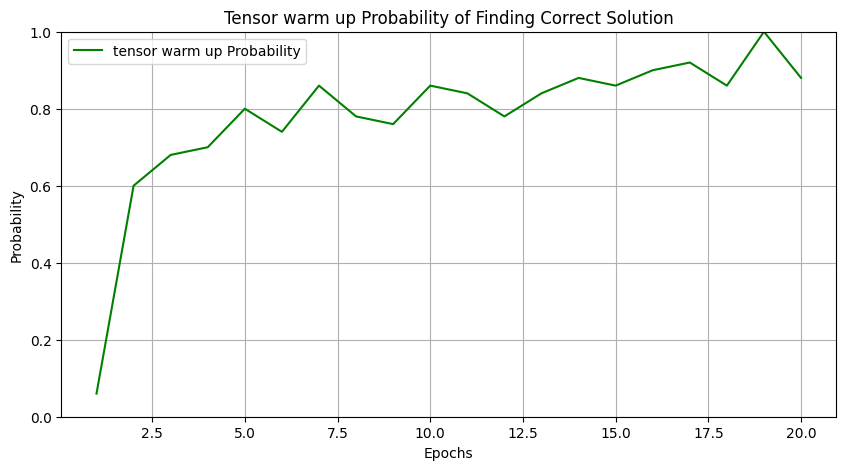
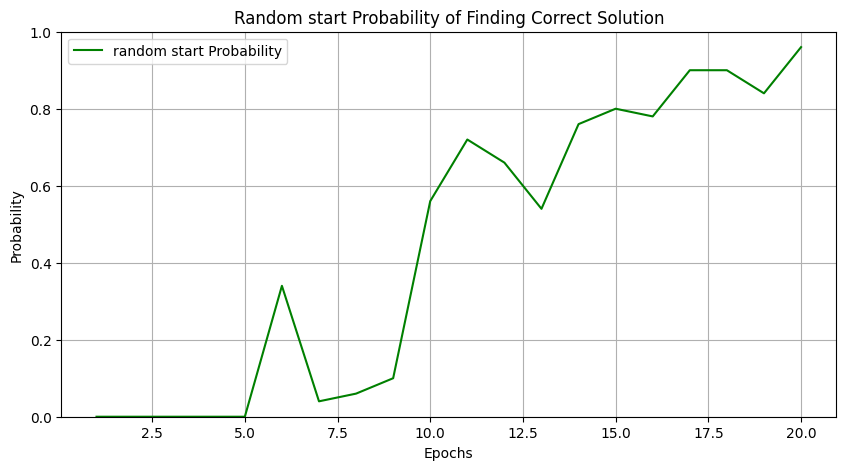
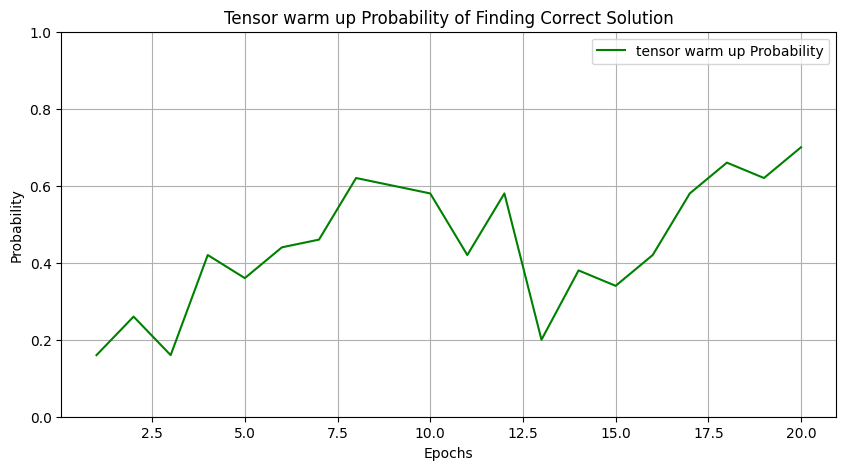
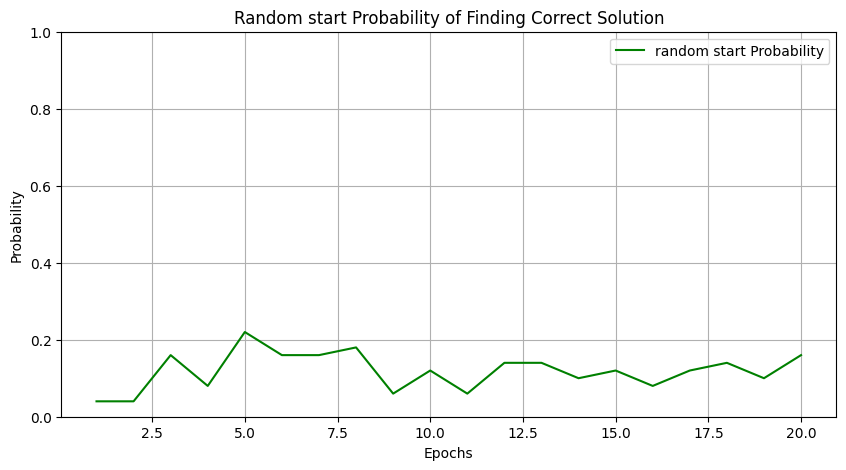

In [44]:
### Single optimization
# Example QUBO matrix
#Q = Q_onsite

# Initial parameters for QAOA
init_params = np.array(param_list)

np.random.seed(seed)
init_params = np.random.uniform(0, 0.1, 2 * depth*20)
init_params_copy = copy.deepcopy(init_params)

#init_params = np.reshape(init_params,(-1))

# RL-QAOA setup
rl_qaoa = RL_QAOA(Q,Q.shape[0],init_params,b_vector = np.array([25.]*int((Q.shape[0]**2))) ,QAOA_depth=depth,gamma = 0.99,learning_rate_init=[0.02,0.05])
final_config = rl_qaoa.rqaoa_execute()
rl_qaoa.n_c = 2
print(f"classical_result : {float(final_config[2])},best : {rl_qaoa.node_assignments}" )


# Execute RQAOA
final_config = rl_qaoa.RL_QAOA(episodes=50,epochs=20,correct_ans=float(final_config[2]))

classical_result : -32.89443803399121,best : [1, 1, 1, 1, 1, -1, -1, -1]


Epoch 1/20:   0%|          | 0/50 [00:00<?, ? episode/s]

Epoch 1/20: 100%|██████████| 50/50 [03:20<00:00,  4.01s/ episode]


  Probability of finding correct solution: 0.0000
  Average reward: 8.919100398021532
  Lowest reward obtained: -4.661674988710537
  Best state at lowest value: [ 1  1  1  1 -1 -1 -1  1]


Epoch 6/20: 100%|██████████| 50/50 [03:15<00:00,  3.91s/ episode]


  Probability of finding correct solution: 0.3400
  Average reward: -23.205461282333157
  Lowest reward obtained: -32.89443803399121
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 11/20: 100%|██████████| 50/50 [02:54<00:00,  3.49s/ episode]


  Probability of finding correct solution: 0.7200
  Average reward: -29.829275367738983
  Lowest reward obtained: -32.89443803399121
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 16/20: 100%|██████████| 50/50 [03:02<00:00,  3.66s/ episode]


  Probability of finding correct solution: 0.7800
  Average reward: -30.32107580363113
  Lowest reward obtained: -32.89443803399121
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 20/20: 100%|██████████| 50/50 [03:25<00:00,  4.10s/ episode]


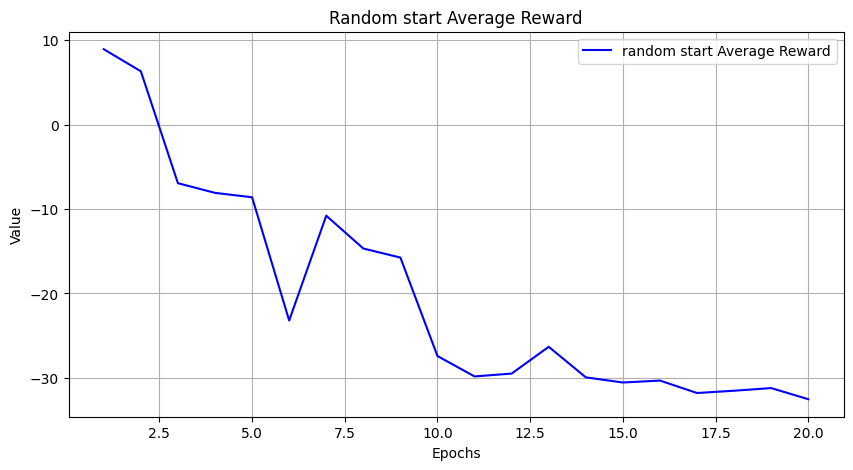

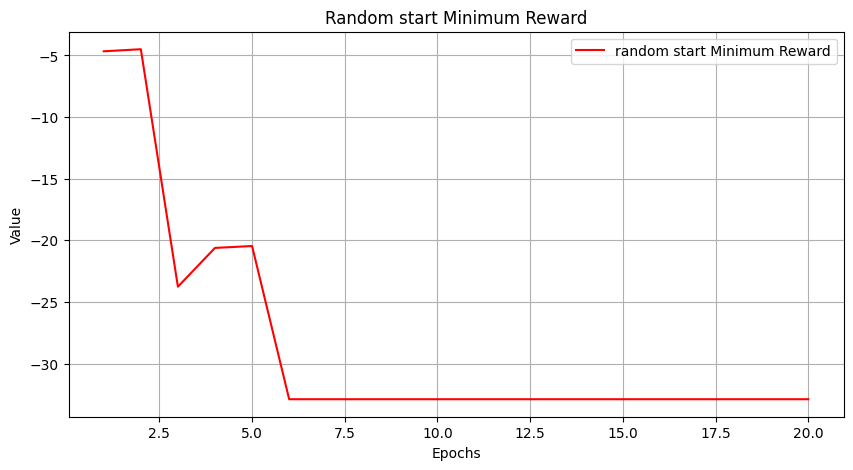

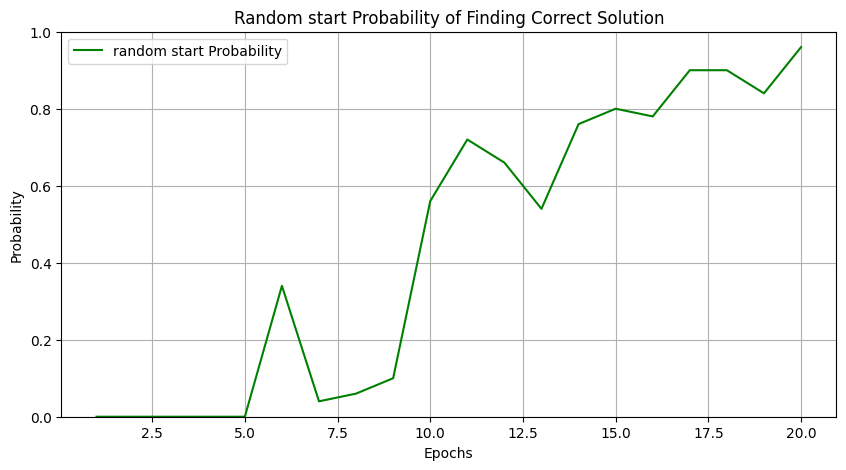

In [45]:
import matplotlib.pyplot as plt

def plot_rl_qaoa_results(avg_values, min_values, prob_values):
    """
    Plots the stored training values of RL_QAOA across epochs with margin.

    - The first plot shows the average values over epochs with margin.
    - The second plot displays the minimum values over epochs with margin.
    - The third plot represents the probability of finding the correct solution.

    Parameters
    ----------
    avg_values : list
        List of average values over epochs.
    min_values : list
        List of minimum values over epochs.
    prob_values : list
        List of probabilities over epochs.

    The x-axis represents the number of epochs in all graphs.
    """

    epochs = range(1, len(avg_values) + 1)

    # Calculate margins for y-axis limits
    avg_min, avg_max = min(avg_values), max(avg_values)
    min_min, min_max = min(min_values), max(min_values)

    avg_margin = (avg_max - avg_min) * 0.05
    min_margin = (min_max - min_min) * 0.05

    # Plot average values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_values, label="random start Average Reward", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Random start Average Reward")
    plt.ylim(avg_min - avg_margin, avg_max + avg_margin)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot minimum values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, min_values, label="random start Minimum Reward", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Random start Minimum Reward")
    plt.ylim(min_min - min_margin, min_max + min_margin)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot probability values
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, prob_values, label="random start Probability", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Probability")
    plt.title("Random start Probability of Finding Correct Solution")
    plt.ylim(0, 1)  # Setting the y-axis range between 0 and 1
    plt.grid(True)
    plt.legend()
    plt.show()
# Example usage with dummy data
avg_values = rl_qaoa.avg_values
min_values = rl_qaoa.min_values
prob_values = rl_qaoa.prob_values

plot_rl_qaoa_results(avg_values, min_values, prob_values)



In [46]:
# Initial parameters for QAOA
init_params = np.array(param_list)
init_params = np.reshape(init_params,(-1))

# RL-QAOA setup
rl_qaoa = RL_QAOA(Q,Q.shape[0],init_params,b_vector = np.array([25.]*int((Q.shape[0]**2))) ,QAOA_depth=depth,gamma = 0.99,learning_rate_init=[0.02,0.05])
final_config = rl_qaoa.rqaoa_execute()
rl_qaoa.n_c = 2
print(f"classical_result : {float(final_config[2])},best : {rl_qaoa.node_assignments}" )


# Execute RQAOA
final_config = rl_qaoa.RL_QAOA(episodes=50,epochs=20,correct_ans=float(final_config[2]))

classical_result : -32.89443803399121,best : [1, 1, 1, 1, 1, -1, -1, -1]


Epoch 1/20: 100%|██████████| 50/50 [03:17<00:00,  3.96s/ episode]


  Probability of finding correct solution: 0.0600
  Average reward: -12.56139313269958
  Lowest reward obtained: -32.89443803399121
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 6/20: 100%|██████████| 50/50 [03:25<00:00,  4.11s/ episode]


  Probability of finding correct solution: 0.7400
  Average reward: -28.280993642676286
  Lowest reward obtained: -32.89443803399121
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 11/20: 100%|██████████| 50/50 [03:27<00:00,  4.15s/ episode]


  Probability of finding correct solution: 0.8400
  Average reward: -29.903979265561198
  Lowest reward obtained: -32.89443803399121
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 16/20: 100%|██████████| 50/50 [03:21<00:00,  4.03s/ episode]


  Probability of finding correct solution: 0.9000
  Average reward: -31.314063898239173
  Lowest reward obtained: -32.89443803399121
  Best state at lowest value: [ 1  1  1  1  1 -1 -1 -1]


Epoch 20/20: 100%|██████████| 50/50 [03:23<00:00,  4.07s/ episode]


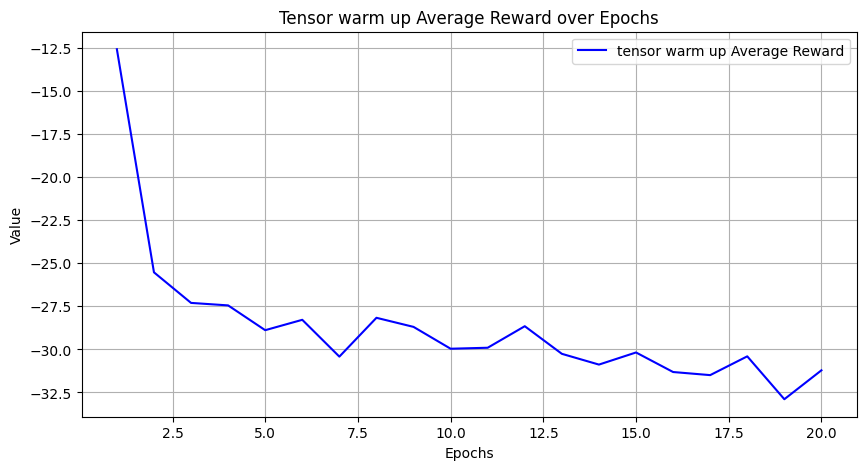

C:\Users\pop75\AppData\Local\Temp\ipykernel_57820\1993208023.py:49: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(min_min - min_margin, min_max + min_margin)


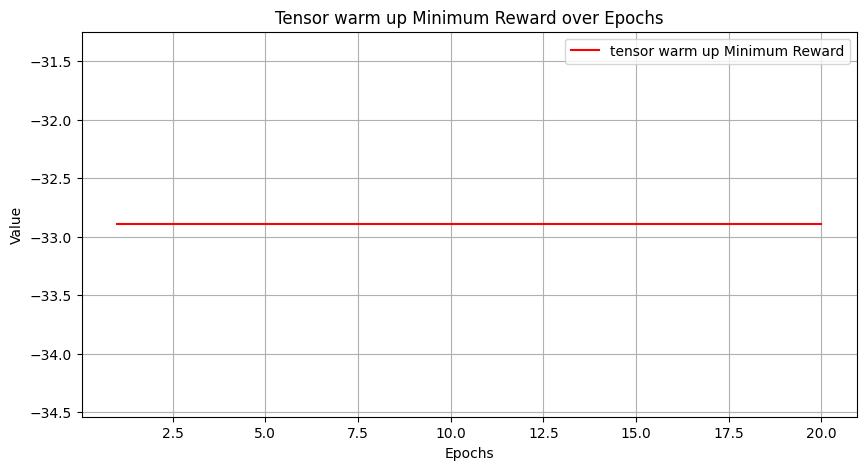

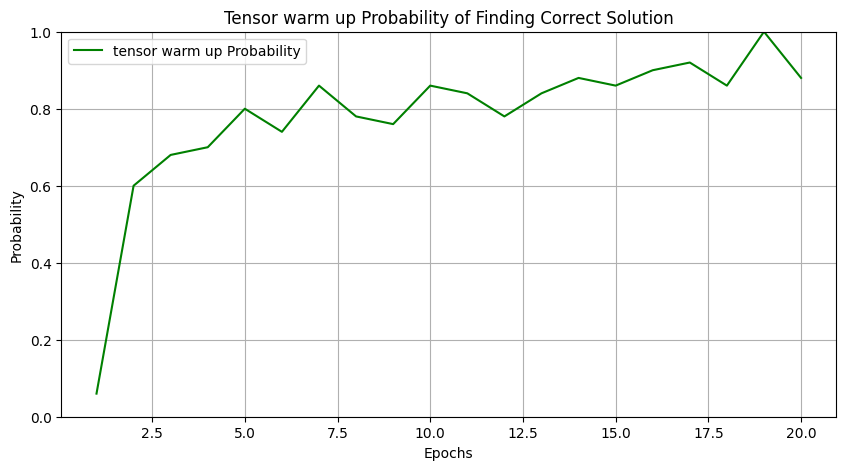

In [47]:
import matplotlib.pyplot as plt

def plot_rl_qaoa_results(avg_values, min_values, prob_values):
    """
    Plots the stored training values of RL_QAOA across epochs with margin.

    - The first plot shows the average values over epochs with margin.
    - The second plot displays the minimum values over epochs with margin.
    - The third plot represents the probability of finding the correct solution.

    Parameters
    ----------
    avg_values : list
        List of average values over epochs.
    min_values : list
        List of minimum values over epochs.
    prob_values : list
        List of probabilities over epochs.

    The x-axis represents the number of epochs in all graphs.
    """

    epochs = range(1, len(avg_values) + 1)

    # Calculate margins for y-axis limits
    avg_min, avg_max = min(avg_values), max(avg_values)
    min_min, min_max = min(min_values), max(min_values)

    avg_margin = (avg_max - avg_min) * 0.05
    min_margin = (min_max - min_min) * 0.05

    # Plot average values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_values, label="tensor warm up Average Reward", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Tensor warm up Average Reward over Epochs")
    plt.ylim(avg_min - avg_margin, avg_max + avg_margin)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot minimum values with margin
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, min_values, label="tensor warm up Minimum Reward", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Tensor warm up Minimum Reward over Epochs")
    plt.ylim(min_min - min_margin, min_max + min_margin)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot probability values
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, prob_values, label="tensor warm up Probability", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Probability")
    plt.title("Tensor warm up Probability of Finding Correct Solution")
    plt.ylim(0, 1)  # Setting the y-axis range between 0 and 1
    plt.grid(True)
    plt.legend()
    plt.show()
# Example usage with dummy data
avg_values = rl_qaoa.avg_values
min_values = rl_qaoa.min_values
prob_values = rl_qaoa.prob_values

plot_rl_qaoa_results(avg_values, min_values, prob_values)
